# **Violence Detection with ConvLSTM**

- Dataset : Real Life Violence Situations Dataset
- Link    : https://www.kaggle.com/mohamedmustafa/real-life-violence-situations-dataset

Preprocessing was made on videos.

- Video Length : 100 frames

- Frame Sizes : 80 x 80

- Channels : 3 (RGB)

- ConvNet : VGG19

In [ ]:
!nvidia-smi

Mon Nov  9 13:15:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.32.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    58W / 149W |   3563MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.layers import Input

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv
import os

from tqdm import tqdm

In [ ]:
# Video reader function
def video_reader(x, end_frame=100):
  cap = cv.VideoCapture(x)
  output = []

  # Frame counter
  frame_num = 0

  # Loop over video
  while True:

    # Read frame
    ret, frame = cap.read()

    # Break condition
    if (ret == None) or (frame_num == end_frame):
      break
    
    # Add frame to output list
    output.append(frame)
    
    frame_num += 1
  
  # Change list type to numpy array
  output = np.array(output)

  return output

In [ ]:
# Data Loader
class ViolenceDataset():
  NVIO = "/content/rs80/non_violence"
  VIO = "/content/rs80/violence"
  LABELS = {NVIO : 0, VIO : 1}

  training_data = []
  viocount = 0
  nviocount = 0

  # Training set maker func
  def training_maker(self):
    # Loop over each label
    for label in self.LABELS:
      print(label)
      # Loop over label folder
      for f in tqdm(os.listdir(label)):
        try:
          path = os.path.join(label, f)
          # Video reader
          vid = video_reader(path)

          self.training_data.append([np.array(vid), np.eye(2)[self.LABELS[label]]])

          # Label counter
          if label == self.NVIO:
            self.nviocount += 1
          elif label == self.VIO:
            self.viocount += 1
        except Exception as e:
          pass

    # Shuffle data
    np.random.shuffle(self.training_data)
    print("\n")
    print(f"NVIO : {self.nviocount}")
    print(f"VIO  : {self.viocount}")
    
    return self.training_data

In [ ]:
dset = ViolenceDataset()
trainset = dset.training_maker()

  0%|          | 5/1000 [00:00<00:20, 48.52it/s]

/content/rs80/non_violence


  1%|          | 9/1000 [00:00<00:12, 81.47it/s]

/content/rs80/violence


100%|██████████| 1000/1000 [00:12<00:00, 82.12it/s]



NVIO : 1000
VIO  : 1000


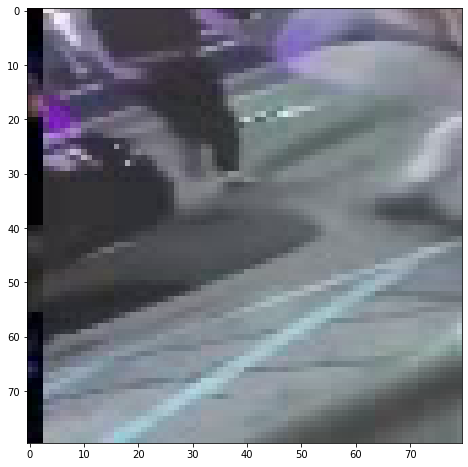

In [ ]:
plt.figure(figsize=(15,8))
plt.imshow(trainset[0][0][0])
plt.show()

In [ ]:
print(f"Non-Violence : [1 0]")
print(f"Violence     : [0 1]")
print("\n")
print(f"Label : {trainset[0][1]}")

Non-Violence : [1 0]
Violence     : [0 1]


Label : [0. 1.]


In [ ]:
# Load pre-trained VGG19 network
vgg19 = VGG19(weights='imagenet', include_top=False, input_tensor=Input(shape=(80,80,3)))

In [ ]:
# Index counter
counter = 0

# Loop over dataset 
for idx in tqdm(range(len(trainset))):
  sequence = []

  # Loop over video data
  for frame in trainset[idx][0]:
    try:
      # Reshape frame for vgg19
      frame = frame.reshape((1, 80, 80, 3))

      # Take vgg19 output
      prediction = vgg19.predict(frame)
      
      # Reshape output for lstm
      prediction = prediction.reshape((1,2048))

      # Add prediction to sequence list
      sequence.append(prediction)
    except:
      pass
  
  # Change list type to numpy array
  sequence = np.array(sequence)

  # Save output for later usage
  np.save(f"processed/video-{counter}.npy", [sequence, trainset[idx][1]])
  counter += 1

100%|██████████| 2000/2000 [2:51:40<00:00,  5.15s/it]


In [ ]:
# Choose only files
data_paths = [i for i in (os.path.join("/content/processed", f) for f in os.listdir("/content/processed")) if os.path.isfile(i)]
len(data_paths)

2000

In [ ]:
# Create label and features
data_x = []
data_y = []

# Loop over folder
for i in tqdm(data_paths):
  
  # Load saved data
  temp_data = np.load(i, allow_pickle=True)
  
  # if frames more than 100
  if temp_data[0].shape[0] >= 100:

    # Add videos' first 100 frames to list
    data_x.append(temp_data[0][0:100])

    # Take label
    data_y.append(temp_data[1])

# Change list to numpy array
data_x = np.array(data_x)
data_y = np.array(data_y)

print("\n")
print(f"X len : {len(data_x)}")
print(f"Y len : {len(data_y)}")

100%|██████████| 2000/2000 [00:02<00:00, 854.64it/s]




X len : 1857
Y len : 1857


In [ ]:
data_x.shape

(1857, 100, 1, 2048)

In [ ]:
# Reshape features for lstm
data_x = data_x.reshape((1857, 100, 2048))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.25, random_state=42)

In [ ]:
# LSTM Network
def build_lstm():
  model = keras.models.Sequential([
                                   keras.layers.LSTM(100, input_shape=(100, 2048), recurrent_dropout=0.1),

                                   keras.layers.Dense(512, activation='relu'),
                                   keras.layers.Dropout(0.3),

                                   keras.layers.Dense(2, activation='sigmoid')
  ])

  return model

lstm = build_lstm()

In [ ]:
# Compile the lstm model
lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               859600    
_________________________________________________________________
dense_2 (Dense)              (None, 512)               51712     
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 1026      
Total params: 912,338
Trainable params: 912,338
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train network
hist = lstm.fit(x_train, y_train, epochs=10, validation_split=0.25)

Epoch 1/10
33/33 [==============================] - 16s 481ms/step - loss: 0.6313 - accuracy: 0.6370 - val_loss: 0.5223 - val_accuracy: 0.7586
Epoch 2/10
33/33 [==============================] - 15s 469ms/step - loss: 0.4040 - accuracy: 0.8266 - val_loss: 0.3574 - val_accuracy: 0.8534
Epoch 3/10
33/33 [==============================] - 16s 479ms/step - loss: 0.2517 - accuracy: 0.9013 - val_loss: 0.3655 - val_accuracy: 0.8477
Epoch 4/10
33/33 [==============================] - 16s 470ms/step - loss: 0.1717 - accuracy: 0.9349 - val_loss: 0.3645 - val_accuracy: 0.8477
Epoch 5/10
33/33 [==============================] - 16s 474ms/step - loss: 0.1043 - accuracy: 0.9684 - val_loss: 0.3058 - val_accuracy: 0.8707
Epoch 6/10
33/33 [==============================] - 15s 469ms/step - loss: 0.0631 - accuracy: 0.9818 - val_loss: 0.3619 - val_accuracy: 0.8793
Epoch 7/10
33/33 [==============================] - 15s 463ms/step - loss: 0.0337 - accuracy: 0.9923 - val_loss: 0.3924 - val_accuracy: 0.8534

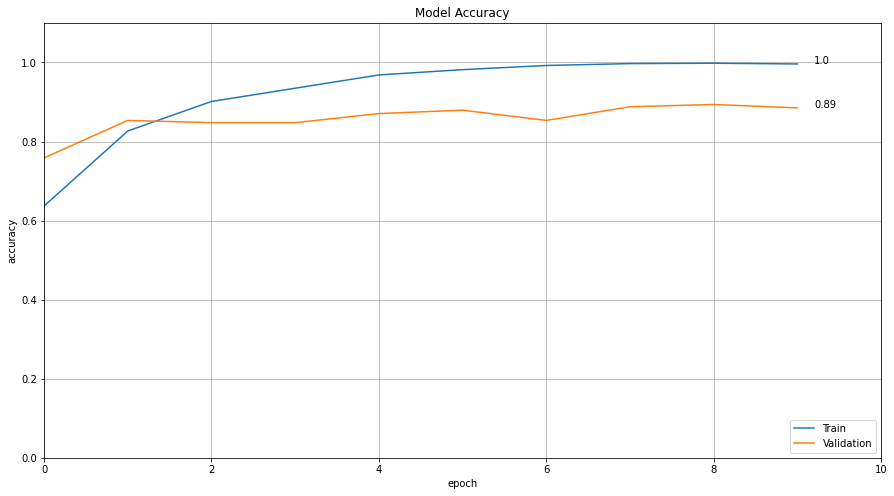

In [ ]:
# Plot train and validation accuracy
plt.figure(figsize=(15,8))
plt.plot(hist.history['accuracy'])
plt.text(9.2, hist.history['accuracy'][-1], str(round(hist.history['accuracy'][-1], 2)))
plt.plot(hist.history['val_accuracy'])
plt.text(9.2, hist.history['val_accuracy'][-1], str(round(hist.history['val_accuracy'][-1], 2)))

plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid()
plt.xlim((0,10))
plt.ylim((0,1.1))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

In [ ]:
# Test Accuracy
lstm.evaluate(x_test, y_test)

15/15 [==============================] - 1s 76ms/step - loss: 0.3595 - accuracy: 0.8839


[0.35952526330947876, 0.8838709592819214]